In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cm
from salishsea_tools import viz_tools
from mocsy import mocsy
import gsw

## Sophie's sites
Elk Bay: 50.2773° N, 125.4388° W


Morning Beach: 48.898611° N 123.335833° W

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [3]:
elk_bay = [50.2773, -125.4388]
morning_beach = [48.898611, -123.335833]

In [4]:
color_sal = '#25738a'
color_temp = '#cc5e0f'
color_omegaA = '#560e1e'
color_ph = '#3f8f6e'

In [5]:
def grid_from_latlon(lat_coord, lon_coord):
    lat_diff = np.abs(bathy.nav_lat - lat_coord)
    lon_diff  = np.abs(bathy.nav_lon - lon_coord)
    sum_of_diff = lat_diff + lon_diff
    intersect_idx = np.unravel_index(np.nanargmin(np.ma.masked_array(sum_of_diff, mask=tmask[5]).filled(np.nan)), sum_of_diff.shape)

    fig, ax = plt.subplots(1,2)
    cb = ax[0].pcolormesh(sum_of_diff)
    ax[0].set_ylabel('GridY')
    ax[0].set_xlabel('GridX')
    viz_tools.set_aspect(ax[0]);
    
    cb2 = ax[1].pcolormesh(np.ma.masked_array(sum_of_diff, mask=tmask[5]))
    ax[1].set_ylabel('GridY')
    ax[1].set_xlabel('GridX')
    viz_tools.set_aspect(ax[1]);
    ax[1].plot(intersect_idx[1], intersect_idx[0], 'r*')

    fig.colorbar(cb, ax=ax[:], label='Lat Diff + Lon Diff')

    print('(y, x): {}'.format(intersect_idx))
    print('Bathy: {} m'.format(bathy['Bathymetry'].isel(y=intersect_idx[0], x=intersect_idx[1]).values))
    

In [6]:
def mocsy_simp(salinity_ds, temp_ds, TA_ds, DIC_ds):
    Tinsitu = np.array(gsw.t_from_CT(salinity_ds, temp_ds, 0))
    Spsu = 35/35.16504 * np.array(salinity_ds)
    TA = np.array(TA_ds)/1000.
    DIC = np.array(DIC_ds)/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH, OmegaA

In [7]:
def make_flats_from_xr(phys_loc, chem_loc):

    sal_flat = phys_loc.vosaline.isel(depth=0, gridY=0, gridX=0).values
    temp_flat = phys_loc.votemper.isel(depth=0, gridY=0, gridX=0).values
    TA_flat = chem_loc.total_alkalinity.isel(depth=0, gridY=0, gridX=0).values
    DIC_flat = chem_loc.dissolved_inorganic_carbon.isel(depth=0, gridY=0, gridX=0).values
    ph_flat, omegaA_flat = mocsy_simp(sal_flat, temp_flat, TA_flat, DIC_flat)

    return sal_flat, temp_flat, omegaA_flat, ph_flat

In [8]:
def plot_timeseries(phys_loc, sal_flat, temp_flat, omegaA_flat, ph_flat, loc_name):

    fig, ax = plt.subplots(4,1,  figsize = (8.5,6), sharex=True)
    fig.suptitle(loc_name)

    ax[0].plot(phys_loc['time'], sal_flat, color=color_sal, alpha=1)
    ax[0].set_ylabel('Salinity [g/kg]')
    ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[0].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

    ax[1].plot(phys_loc['time'], temp_flat, color=color_temp, alpha=1)
    ax[1].set_ylabel('Temperature [degC]')
    ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[1].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

    ax[2].plot(phys_loc['time'], omegaA_flat, color=color_omegaA, alpha=1)
    ax[2].set_ylabel('Omega A')
    ax[2].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[2].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

    ax[3].plot(phys_loc['time'], ph_flat, color=color_ph, alpha=1)
    ax[3].set_ylabel('pH')
    ax[3].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[3].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))
    ax[3].set_xlim([phys_loc['time'].min(), phys_loc['time'].max()])

In [9]:
def make_df(phys_loc, ph_flat, omegaA_flat):
    vars_loc_df = phys_loc.isel(depth=0, gridY=0, gridX=0).to_dataframe().drop(columns=['depth', 'gridY', 'gridX']).reset_index()
    vars_loc_df['ph'] = ph_flat
    vars_loc_df['omegaA'] = omegaA_flat
    vars_loc_df['month-day'] = vars_loc_df['time'].dt.strftime('%m-%d')
    vars_loc_df['year'] = vars_loc_df['time'].dt.strftime('%Y')

    vars_loc_df_mean = vars_loc_df.groupby('month-day').mean(numeric_only=True).reset_index()

    return vars_loc_df, vars_loc_df_mean

In [10]:
def plot_stacked_timeseries(vars_loc_df, vars_loc_df_mean, loc_name):
    fig, ax = plt.subplots(4,1,  figsize = (8.5,6), sharex=True)
    fig.suptitle(loc_name)

    for year in vars_loc_df['year'].unique():

        ax[0].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['vosaline'], color=color_sal, alpha=0.3)
        ax[0].set_ylabel('Salinity [g/kg]')
        ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[0].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

        ax[1].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['votemper'], color=color_temp, alpha=0.3)
        ax[1].set_ylabel('Temperature [degC]')
        ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[1].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

        ax[2].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['omegaA'], color=color_omegaA, alpha=0.3)
        ax[2].set_ylabel('Omega A')
        ax[2].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[2].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

        ax[3].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['ph'], color=color_ph, alpha=0.3)
        ax[3].set_ylabel('pH')
        ax[3].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[3].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))
        ax[3].set_xlim([vars_loc_df['month-day'].min(), vars_loc_df['month-day'].max()])
        ax[3].set_xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])

    ax[0].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['vosaline'], color='k', alpha=1)
    ax[1].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['votemper'], color='k', alpha=1)
    ax[2].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['omegaA'], color='k', alpha=1)
    ax[3].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['ph'], color='k', alpha=1)

In [11]:
def plot_hist(vars_loc_df, loc_name):

    bin_num = 15

    fig, ax = plt.subplots(2,2, figsize = (8.5, 5), sharex=True)
    fig.tight_layout(pad=1.6)
    fig.suptitle(loc_name)

    ax[0,0].set_ylabel(r'Salinity [g/kg]')
    ax[0,0].hist(vars_loc_df['vosaline'], bins=bin_num, color=color_sal, edgecolor='black', orientation='horizontal')

    ax[1,0].set_ylabel(r'Temperature $^{\circ}$C')
    ax[1,0].set_xlabel(r'# Days')
    ax[1,0].hist(vars_loc_df['votemper'], bins=bin_num, color=color_temp, edgecolor='black', orientation='horizontal')

    ax[0,1].set_ylabel(r'OmegaA')
    ax[0,1].hist(vars_loc_df['omegaA'], bins=bin_num, color=color_omegaA, edgecolor='black', orientation='horizontal')

    ax[1,1].set_ylabel(r'pH')
    ax[1,1].set_xlabel(r'# Days')
    ax[1,1].hist(vars_loc_df['ph'], bins=bin_num, color=color_ph, edgecolor='black', orientation='horizontal')

In [12]:
def print_stats(vars_loc_df):
    print('---- Salinity ---------------- \n\
    Mean:               {:.2f} (g/kg) \n\
    Median:             {:.2f} (g/kg) \n\
    Standard Deviation: {:.2f} (g/kg)'.format(vars_loc_df['vosaline'].mean(), np.median(vars_loc_df['vosaline']), vars_loc_df['vosaline'].std()))

    print('---- Temperature ---------------- \n\
    Mean:               {:.2f} (degC) \n\
    Median:             {:.2f} (degC) \n\
    Standard Deviation: {:.2f} (degC)'.format(vars_loc_df['votemper'].mean(), np.median(vars_loc_df['votemper']), vars_loc_df['votemper'].std()))

    print('---- OmegaA ---------------- \n\
    Mean:               {:.2f} \n\
    Median:             {:.2f} \n\
    Standard Deviation: {:.2f}'.format(vars_loc_df['omegaA'].mean(), np.median(vars_loc_df['omegaA']), vars_loc_df['omegaA'].std()))

    print('---- pH ---------------- \n\
    Mean:               {:.2f} \n\
    Median:             {:.2f} \n\
    Standard Deviation: {:.2f}'.format(vars_loc_df['ph'].mean(), np.median(vars_loc_df['ph']), vars_loc_df['ph'].std()))

In [13]:
def show_for_loc(loc_name, phys_loc, chem_loc):

    print(loc_name)

    sal_flat, temp_flat, omegaA_flat, ph_flat = make_flats_from_xr(phys_loc, chem_loc)
    plot_timeseries(phys_loc, sal_flat, temp_flat, omegaA_flat, ph_flat, loc_name)
    vars_loc_df, vars_loc_df_mean = make_df(phys_loc, ph_flat, omegaA_flat)
    plot_stacked_timeseries(vars_loc_df, vars_loc_df_mean, loc_name)
    plot_hist(vars_loc_df, loc_name)
    print_stats(vars_loc_df)

## Elk Bay

(y, x): (808, 126)
Bathy: 24.875 m


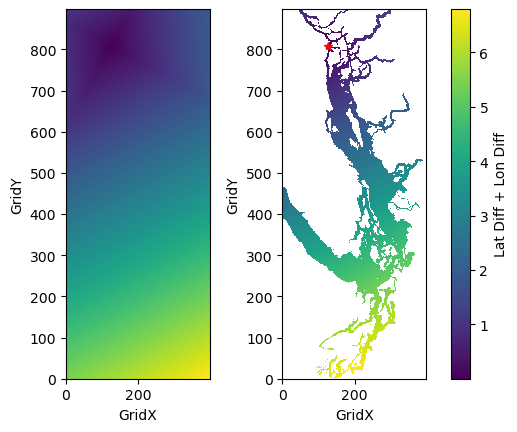

In [14]:
grid_from_latlon(elk_bay[0], elk_bay[1])

Elk Bay
---- Salinity ---------------- 
    Mean:               29.74 (g/kg) 
    Median:             29.79 (g/kg) 
    Standard Deviation: 0.42 (g/kg)
---- Temperature ---------------- 
    Mean:               9.32 (degC) 
    Median:             9.32 (degC) 
    Standard Deviation: 1.47 (degC)
---- OmegaA ---------------- 
    Mean:               1.06 
    Median:             1.03 
    Standard Deviation: 0.10
---- pH ---------------- 
    Mean:               7.84 
    Median:             7.84 
    Standard Deviation: 0.04


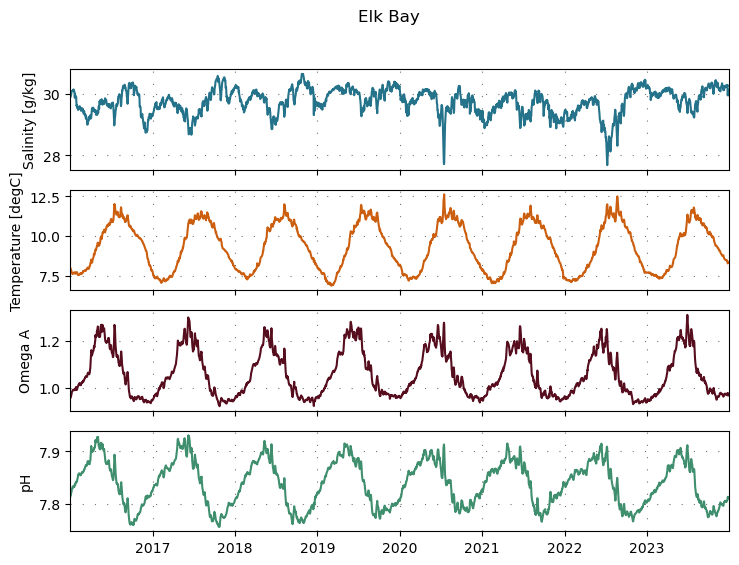

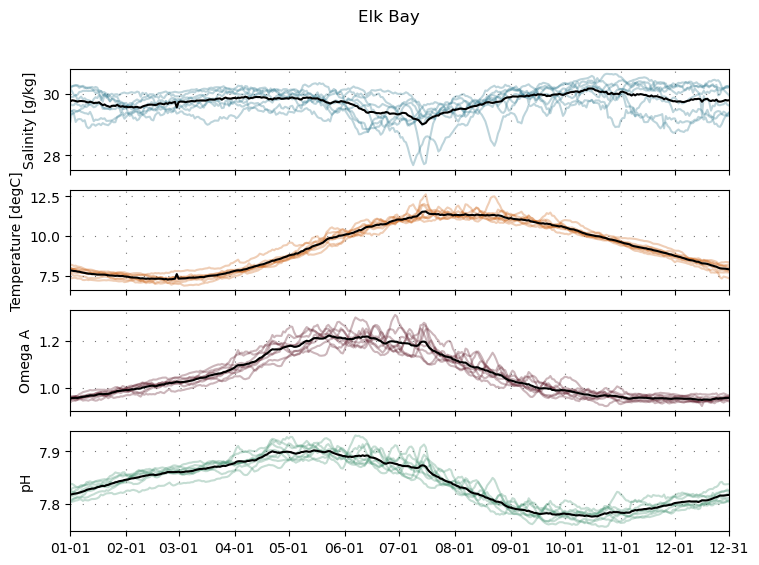

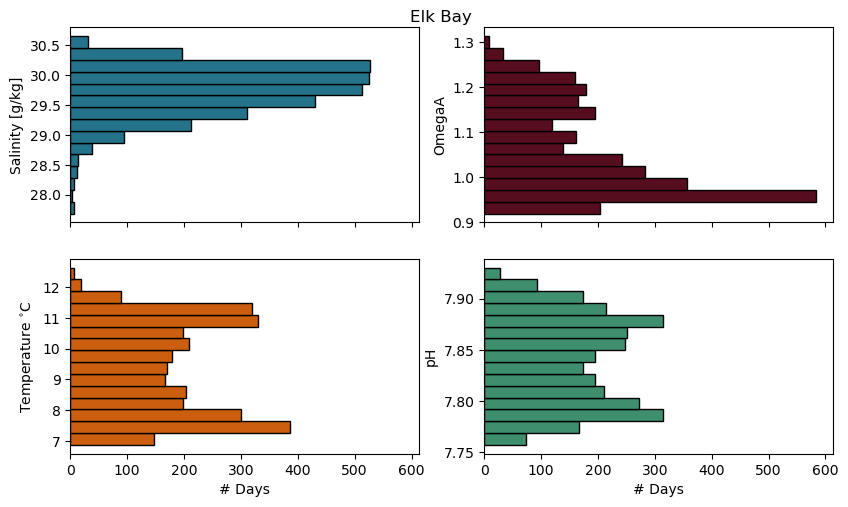

In [15]:
phys_elk_bay = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_phys_elk_bay_20160101_20231231.nc')
chem_elk_bay = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_chem_elk_bay_20160101_20231231.nc')

show_for_loc('Elk Bay', phys_elk_bay, chem_elk_bay)

## Morning Beach

(y, x): (390, 262)
Bathy: 26.75 m


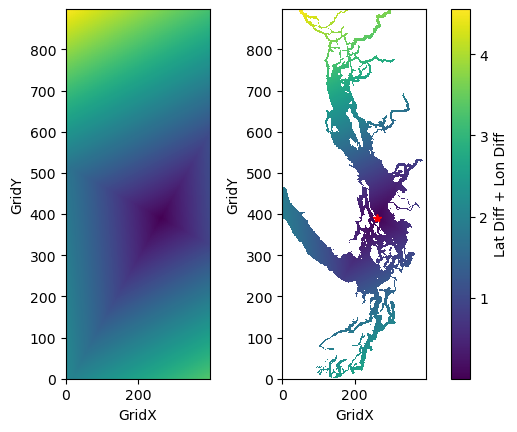

In [16]:
grid_from_latlon(morning_beach[0], morning_beach[1])

Morning Beach
---- Salinity ---------------- 
    Mean:               27.03 (g/kg) 
    Median:             27.62 (g/kg) 
    Standard Deviation: 2.43 (g/kg)
---- Temperature ---------------- 
    Mean:               11.09 (degC) 
    Median:             10.29 (degC) 
    Standard Deviation: 3.37 (degC)
---- OmegaA ---------------- 
    Mean:               1.39 
    Median:             1.28 
    Standard Deviation: 0.43
---- pH ---------------- 
    Mean:               7.97 
    Median:             7.95 
    Standard Deviation: 0.14


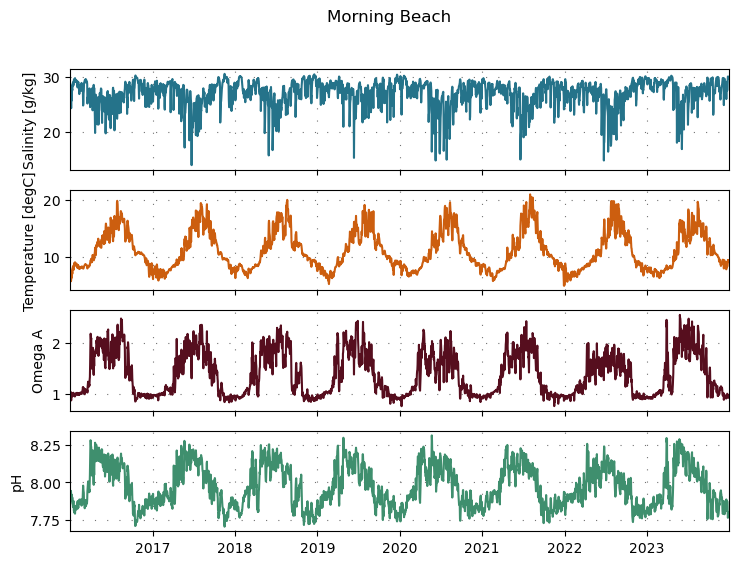

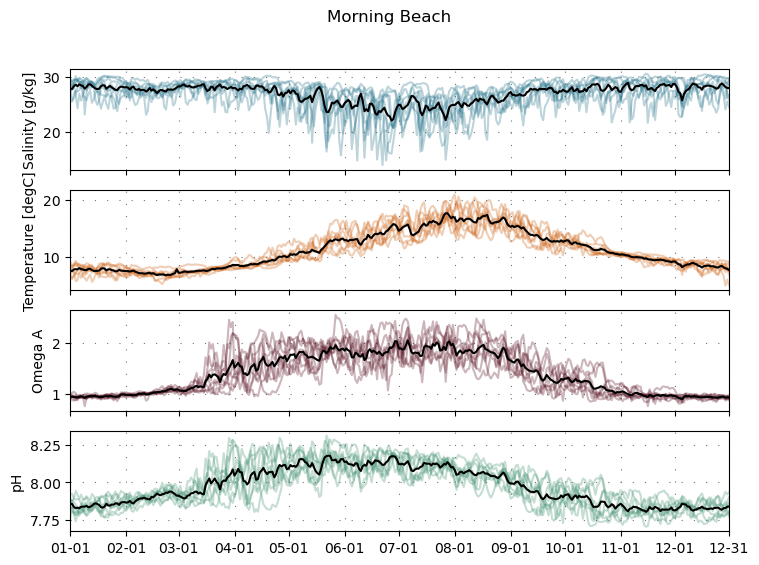

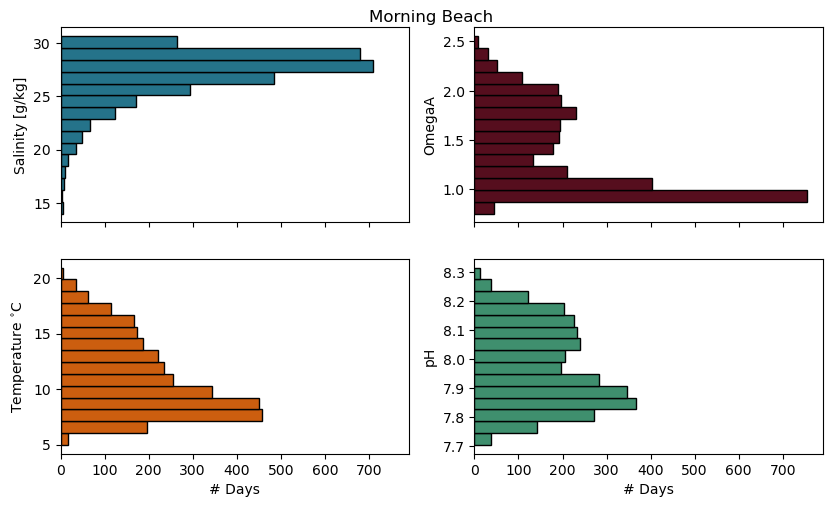

In [17]:
phys_morning_beach = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_phys_morning_beach_20160101_20231231.nc')
chem_morning_beach = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_chem_morning_beach_20160101_20231231.nc')

show_for_loc('Morning Beach', phys_morning_beach, chem_morning_beach)